<a href="https://colab.research.google.com/github/adammoss/bnn_hmc/blob/main/results/Mirabest_MCD_lenet_64_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import shutil
import subprocess
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
!nvidia-smi

Mon Sep  5 21:43:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install astro-datasets --upgrade
!pip install tensorflow_datasets --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for astro-datasets: filename=astro_datasets-0.0.10-py3-none-any.whl size=15992 sha256=566e058757a87c7966c3d3774e4b452a735f639fa97aba52410535b48b7d13cb
  Stored in directory: /root/.cache/pip/wheels/33/b2/9d/97c264f6addbd178fe1c8ff119617e1515cb8c0d0f220605cf
Successfully built astro-datasets
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
shutil.rmtree('bnn_hmc', ignore_errors=True)

In [5]:
!git clone https://github.com/adammoss/bnn_hmc

Cloning into 'bnn_hmc'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 592 (delta 39), reused 12 (delta 4), pack-reused 531
Receiving objects: 100% (592/592), 1.09 MiB | 11.16 MiB/s, done.
Resolving deltas: 100% (420/420), done.


In [6]:
!cd bnn_hmc && git checkout dropout_wip

Branch 'dropout_wip' set up to track remote branch 'dropout_wip' from 'origin'.
Switched to a new branch 'dropout_wip'


In [7]:
# https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install --upgrade https://storage.googleapis.com/jax-releases/cuda111/jaxlib-0.1.65+cuda111-cp37-none-manylinux2010_x86_64.whl
!pip install jax==0.2.12
!pip install dm-haiku==0.0.5.dev0 optax==0.0.6 chex==0.0.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 189.4 MB 16 kB/s 
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.14+cuda11.cudnn805
    Uninstalling jaxlib-0.3.14+cuda11.cudnn805:
      Successfully uninstalled jaxlib-0.3.14+cuda11.cudnn805
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 590 kB 15.4 MB/s 
  Created wheel for jax: filename=jax-0.2.12-py3-none-any.whl size=682487 sha256=0d395a4d3a7c5e11d28f206434db7c913809e80aeb17782a8aa8cc072e660be6
  Stored in directory: /root/.cache/pip/wheels/f6/4d/e5/73eec5070b77f25664c67bd793d4eb97f41bbf9be7afafd15e
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.3.14
    Uninstalling jax-0.3.14:
      Successfully uninstalled jax-0.3.14
Looking in indexes: https://pypi.org/simple, https://us-python.p

In [8]:
for i, root in enumerate(glob.glob('/content/runs/*/')):
  shutil.rmtree(root, ignore_errors=True)

In [9]:
!python3 bnn_hmc/scripts/run_sgd.py --seed=0 --weight_decay=10 --dir=runs/sgd/mirabestc/ \
--dataset_name=mirabest/confident --model_name=lenet_dropout --init_step_size=3e-7 --num_epochs=200 --eval_freq=5 \
--batch_size=53 --save_freq=5 --optimizer=SGD --train_split=train[:80%] --test_split=train[80%:] --patience 10 \
--dropout_rate 0.1 --image_size=64

JAX sees the following devices: [GpuDevice(id=0, process_index=0)]
TF sees the following devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
2022-09-05 21:44:37.651307: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "NOT_FOUND: Error executing an HTTP request: HTTP response code 404".
Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0% 0/1 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0% 0/1 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 100% 1/1 [00:00<00:00,  3.06 url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 100% 1/1 [00:00<00:00,  3.06 url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...:   0% 0/1 [00

In [10]:
!python3 bnn_hmc/scripts/run_sgd.py --seed=0 --weight_decay=10 --dir=runs/sgd/mirabestc/ \
--dataset_name=mirabest/confident --model_name=lenet_dropout --init_step_size=3e-7 --num_epochs=200 --eval_freq=5 \
--batch_size=53 --save_freq=5 --optimizer=SGD --eval_split=test --repeats 10 --dropout_rate 0.1 --image_size=64

JAX sees the following devices: [GpuDevice(id=0, process_index=0)]
TF sees the following devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Continuing the run from the last saved checkpoint
bnn_hmc/scripts/run_sgd.py:190: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predict_fn(net_apply, params, net_state, test_set, key))
{'accuracy': DeviceArray(0.84615386, dtype=float32), 'nll': 0.36847645, 'ece': DeviceArray(0.12039611, dtype=float32)}


In [13]:
softmax = []
for i, root in enumerate(glob.glob('/content/runs/sgd/mirabestc/*/predictions*npy')):
  prediction = np.load(root)
  softmax.append(np.squeeze(prediction))
softmax = np.array(softmax)

In [14]:
def uncertainty(softmax):
  # Per example softmax with shape(num_examples, num_classes)
  predictive_entropy = 0
  single_pass_entropy = 0
  for i in range(softmax.shape[1]):
    # Sum over classes
    predictive_entropy += -np.mean(softmax[:,i])*np.log(np.mean(softmax[:,i]))
    single_pass_entropy += -softmax[:,i]*np.log(softmax[:,i])
  single_pass_entropy = np.mean(single_pass_entropy)
  mutual_info = predictive_entropy - single_pass_entropy
  return predictive_entropy, single_pass_entropy, mutual_info

In [15]:
predictive_entropies = [] 
single_pass_entropies = []
mutual_infos = []
for i in range(softmax.shape[1]):
  predictive_entropy, single_pass_entropy, mutual_info = uncertainty(softmax[:,i,:])
  predictive_entropies.append(predictive_entropy)
  single_pass_entropies.append(single_pass_entropy)
  mutual_infos.append(mutual_info)
print('Predictive entropy:', np.mean(predictive_entropies), np.std(predictive_entropies))
print('Single pass entropy:', np.mean(single_pass_entropies), np.std(single_pass_entropies))
print('Mutual info:', np.mean(mutual_infos), np.std(mutual_infos))

Predictive entropy: 0.4678251074533014 0.1803515698319326
Single pass entropy: 0.40991157 0.15922916
Mutual info: 0.05791355119436048 0.04405100288897311


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


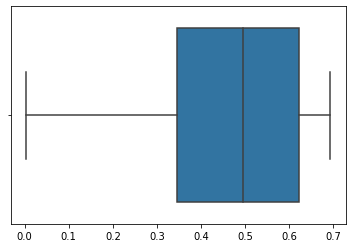

In [16]:
sns.boxplot(predictive_entropies)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


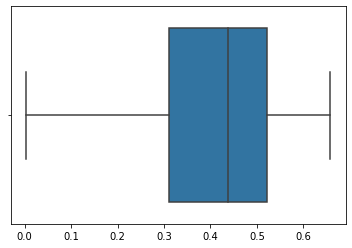

In [17]:
sns.boxplot(single_pass_entropies)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


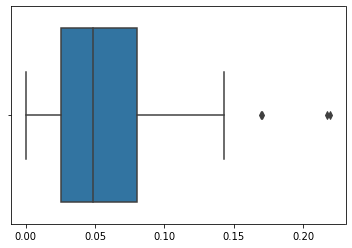

In [18]:
sns.boxplot(mutual_infos)
plt.show()